I had to downgrade `numpy` and `scipy` in order to use some of the libraries of `statsmodels`.    
```
pip install scipy==1.2.0    
pip install numpy==1.16.0
pip install statsmodels
```

In [1]:
import os
import pandas as pd 
import numpy as np
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.arima_model import ARIMA
import math

import matplotlib.pylab as plt
# %matplotlib inline

In [2]:
os.chdir('..')

In [3]:
! pwd

/Users/A.IVA/Documents/jupyter_notebooks/rest/coursera_and_blogs/time_series


### 1 Load data

In [4]:
data_dir = os.path.join('data', 'kaggle_stocks', 'Stocks')

dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')

data = pd.read_csv(os.path.join(data_dir, 'tsla.us.txt'), index_col=0, date_parser=dateparse)

In [5]:
display(data.head(2))
display(data.tail(2))

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2010-06-28,17.0,17.0,17.00,17.00,0,0
2010-06-29,19.0,25.0,17.54,23.89,18783276,0


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2017-11-09,302.5,304.46,296.30,302.99,5440335,0
2017-11-10,302.5,308.36,301.85,302.99,4621912,0


### 2 Some visualizations

##### 2.1 smoothed values

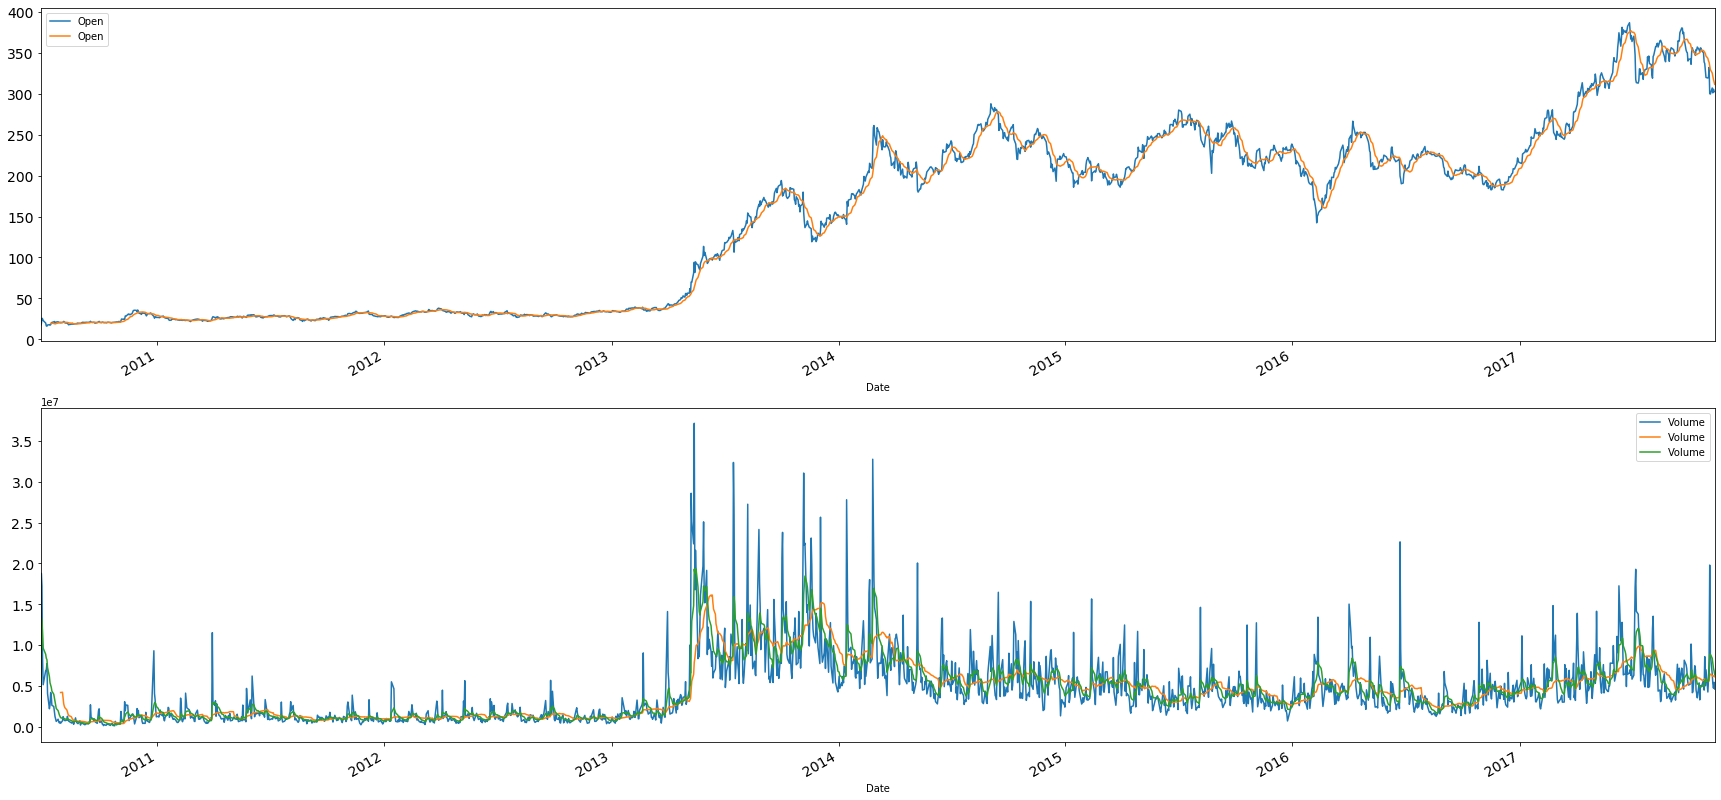

In [8]:
fsize=(30,15)
fig, axs = plt.subplots(2,1) 
data[['Open']].plot(figsize=fsize, label= 'Open', fontsize=14, ax=axs[0]) 
data[['Open']].rolling(12).mean().plot(figsize=fsize, label= 'Open avg 12', fontsize=14, ax=axs[0]) 
data[['Volume']].plot(figsize=fsize, label= 'Volume', fontsize=14, ax=axs[1]) 
data[['Volume']].rolling(24).mean().plot(figsize=fsize, label= 'Volume avg 24', fontsize=14, ax=axs[1]) 
data[['Volume']].ewm(alpha=0.2, adjust=True, ignore_na=False).mean().plot(figsize=fsize, label= 'Volume EWM', fontsize=14, ax=axs[1])  
plt.legend(loc='best') 
plt.show()

In [ ]:
https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

##### 2.2 seasonal decomposition

Enforce specific frequency in the occurance of data values via: 
- `df.asfreq('D', method='ffill')`   
- `df[<column>].resample('MS').mean()`   

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# seasonal_decompose(data['Open'], model='additive')  # ValueError: You must specify a freq or x must be a pandas object with a timeseries index with a freq not set to None
# seasonal_decompose(data.reset_index()[['Open']], model='additive')  # AttributeError: 'RangeIndex' object has no attribute 'inferred_freq'
decomposition = seasonal_decompose(data.asfreq('D', method='ffill')['Open']['2014-07-01':], model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

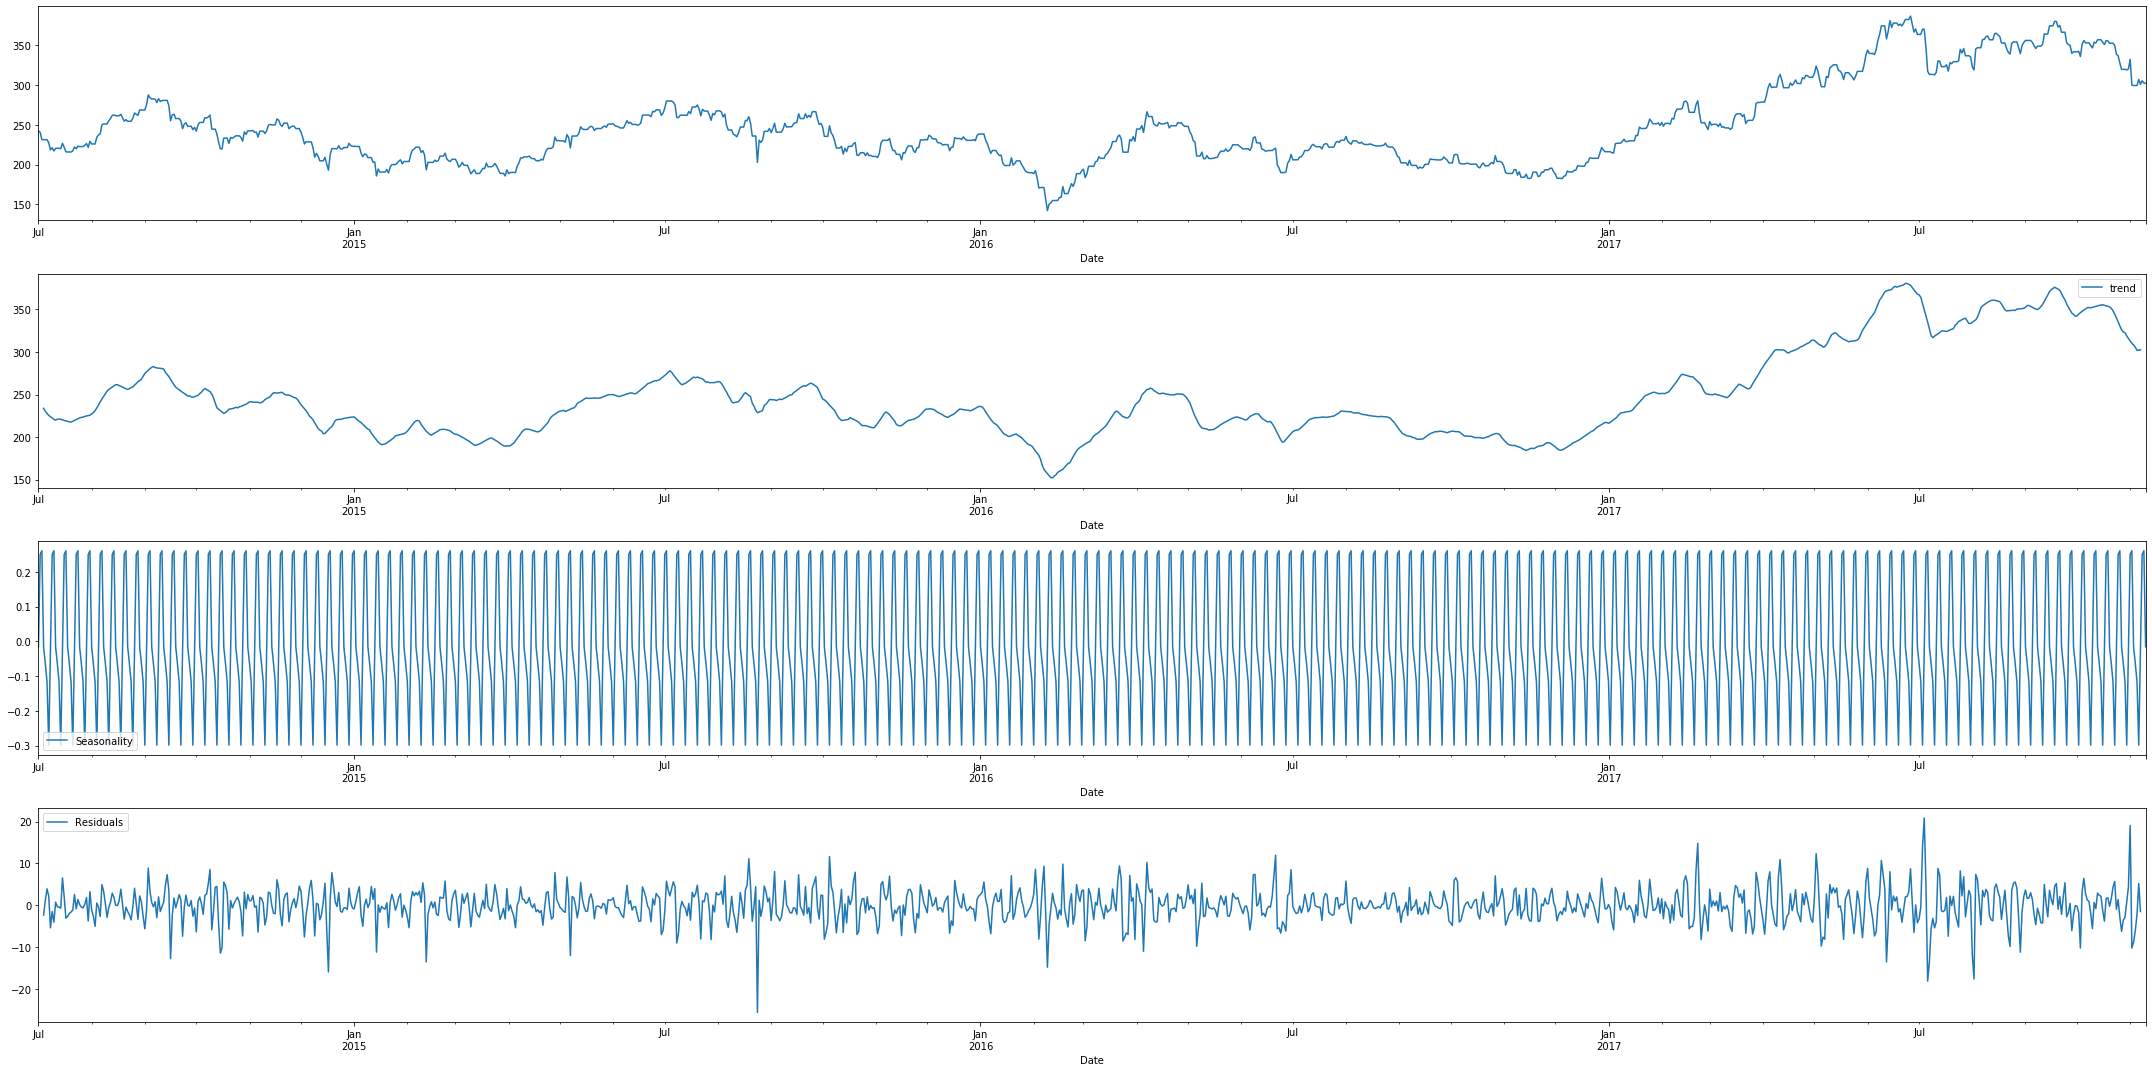

In [12]:
fsize=(30,15)

plt.subplot(411)
data.asfreq('D', method='ffill')['Open']['2014-07-01':].plot(kind="line",figsize=fsize,label='Original')
plt.subplot(412)
trend.plot(kind="line",figsize=fsize,label='trend')
plt.legend(loc='best')
plt.subplot(413)
seasonal.plot(kind="line",figsize=fsize,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
residual.plot(kind="line",figsize=fsize,label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Another option

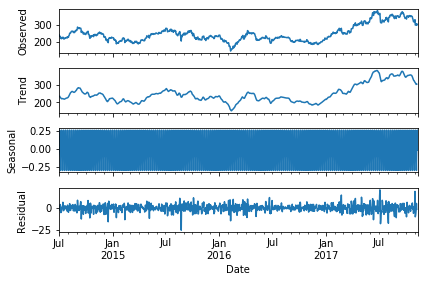

In [49]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(data.asfreq('D', method='ffill')['Open']['2014-07-01':], model='additive')
fig = decomposition.plot()
plt.show()

##### 2.3 detrend time series

In [13]:
from statsmodels.tsa.tsatools import detrend

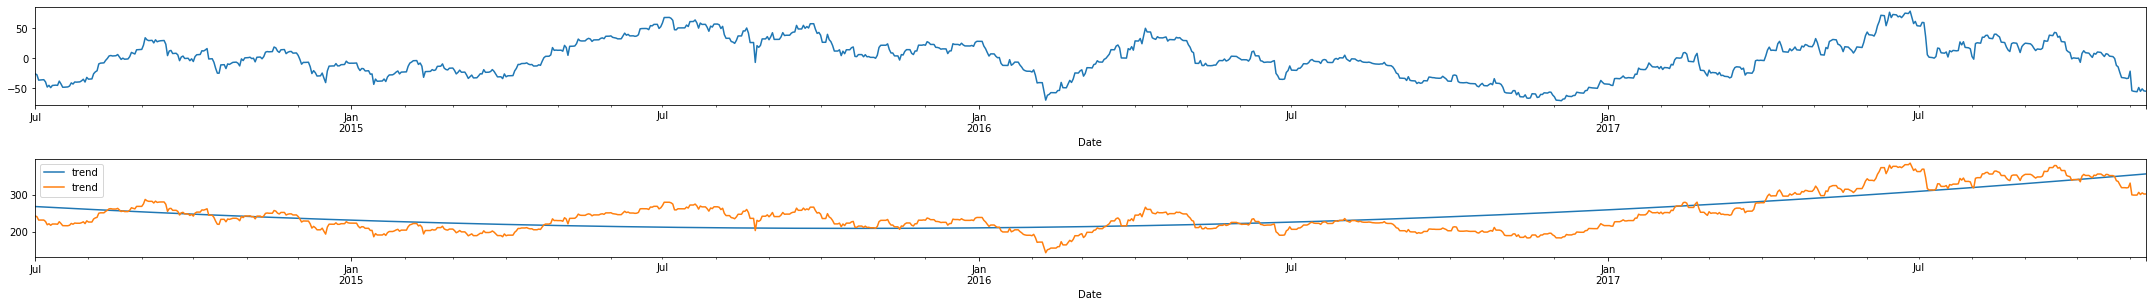

In [14]:
detrend_el = detrend(data.asfreq('D', method='ffill')['Open']['2014-07-01':], order=2)
trend_el = data.asfreq('D', method='ffill')['Open']['2014-07-01':] - detrend_el

fsize=(30,8)

plt.subplot(411)
detrend_el.plot(kind="line",figsize=fsize,label='Original')
plt.subplot(412)
trend_el.plot(kind="line",figsize=fsize,label='trend')
data.asfreq('D', method='ffill')['Open']['2014-07-01':].plot(kind="line",figsize=fsize,label='trend')
plt.legend(loc='best')
plt.tight_layout()

##### 2.4 use some of the available prediction methods (AR)

**AR**    
I had to add a line in the `fit()` method of the `AR` class in `ar_model.py`.    
```
self.params = params
```
I do not know if that are the parameters that the predict function wants to have.     

**EDIT**    
The hack above is not necessary any more. Just use an instance of class `<model>_Result`.

In [24]:
from statsmodels.tsa.ar_model import AR

train = data['Open']['2014-07-01':'2017-04-01'].values
test = data['Open']['2017-04-01':].values[:50]

In [25]:
model_ar = AR(endog=train)
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)

In [26]:
model_ar_dir = ('model_3_ar_arima_etx')
if not os.path.exists(model_ar_dir):
    os.makedirs(model_ar_dir)

model_ar_result.save( os.path.join(model_ar_dir, 'model_ar.pickle'), remove_data=False)

Just a check if I have understood how the prediction is done.

In [36]:
print('model parameters')
print(model_ar_result.params)

print('\nbeginning (first entry can not be predicted)')
print(model_ar.predict(model_ar_result.params, start=1,end=3))
print(model_ar_result.predict(                 start=1,end=3))
print((model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[:3]).reshape(-1))

print('\nend') 
print(model_ar.predict(model_ar_result.params, start=model_ar.endog.shape[0]-3,end=model_ar.endog.shape[0]-1))
print(model_ar_result.predict(                 start=model_ar.endog.shape[0]-3,end=model_ar.endog.shape[0]-1))
print((model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[-4:-1]).reshape(-1))

print('\nout of sample predictions') 
print(model_ar.predict(model_ar_result.params, start=model_ar.endog.shape[0],end=model_ar.endog.shape[0]+2))
print(model_ar_result.predict(                 start=model_ar.endog.shape[0],end=model_ar.endog.shape[0]+2))

# manual out of sample calculation
v1 = model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[-1]
v2 = model_ar_result.params[0] + model_ar_result.params[1]*v1
v3 = model_ar_result.params[0] + model_ar_result.params[1]*v2
print(np.array([v1, v2, v3]).reshape(-1))

model parameters
[5.219234   0.97721209]

beginning (first entry can not be predicted)
[242.15407739 240.39509563 231.38520016]
[242.15407739 240.39509563 231.38520016]
[242.15407739 240.39509563 231.38520016]

end
[275.92652723 277.21644719 276.92328356]
[275.92652723 277.21644719 276.92328356]
[275.92652723 277.21644719 276.92328356]

out of sample predictions
[277.5975599  276.49092575 275.40950947]
[277.5975599  276.49092575 275.40950947]
[277.5975599  276.49092575 275.40950947]


The idea to just replace the data contained in `model_ar.endog` does not work.

In [10]:
model_ar.data.endog=None
model_ar.data.endog
model_ar.endog = None # this one influences the predictions
model_ar.endog = train.reshape(-1, 1)[:5]
print(model_ar.predict(model_ar_result.params, start=1,end=3)) # This produced the results that I have expected.

[242.15407739 240.39509563 231.38520016]


In [12]:
model_ar.data.endog=None
model_ar.data.endog
model_ar.endog = None # this one influences the predictions
model_ar.endog = train.reshape(-1, 1)[-5:]
print(model_ar.predict(model_ar_result.params, start=1,end=3)) # But here I was dissapointed

[242.15407739 240.39509563 231.38520016]


Try to load a model. Works as expected

In [14]:
from statsmodels.tsa.ar_model import ARResults

something = ARResults.load(os.path.join(model_ar_dir, 'model_ar.pickle'))
# ARResults(model, params, normalized_cov_params=None, scale=1.0)

In [22]:
print('the new thing is an instance of class \t', type(something))
print(something.predict(start=1,end=3, dynamic=False))
print(something.predict(start=train.shape[0]-3,end=train.shape[0]-1))

the new thing is an instance of class 	 <class 'statsmodels.tsa.ar_model.ARResultsWrapper'>
[242.15407739 240.39509563 231.38520016]
[275.92652723 277.21644719 276.92328356]


Look at the case where you want to predict the `T`-th out of training sample value,   
by using the real/observed `T, T-1, T-2, ..` values.     
Apparently, the only, way to achieve this is to:  
 1. include the newly obeserved value to the rest of obeserved value to the previous values that are used to fit the model  
 2. train the model again using the new slightly larger data set .  
 3. make a `prediction` for the next step and add the `observed`/`real` value to the data used for training as in step 1.

In [71]:
model_ar = AR(endog=train)
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)

In [72]:
# This does not use the new out of sample values for training
# new_entry = model_ar.predict(model_ar_result.params, start=model_ar.endog.shape[0],end=model_ar.endog.shape[0])
# new_entry = model_ar_result.predict(                 start=model_ar.endog.shape[0],end=model_ar.endog.shape[0])
# model_ar.endog = np.append(model_ar.endog, new_entry.reshape(-1,1), axis=0)
# model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)

# This should work
new_entry = model_ar_result.predict( start=model_ar.endog.shape[0],end=model_ar.endog.shape[0])
model_ar = AR(endog=np.append(model_ar.endog, new_entry.reshape(1,-1), axis=0))  # I should use the test data not the `new_entry`
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)

In [73]:
print('model parameters')
print(model_ar_result.params)

print('\nbeginning (first entry can not be predicted)')
print(model_ar.predict(model_ar_result.params, start=1,end=3))
print(model_ar_result.predict(                 start=1,end=3))
print((model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[:3]).reshape(-1))

print('\nend') 
print(model_ar.predict(model_ar_result.params, start=model_ar.endog.shape[0]-3,end=model_ar.endog.shape[0]-1))
print(model_ar_result.predict(                 start=model_ar.endog.shape[0]-3,end=model_ar.endog.shape[0]-1))
print((model_ar_result.params[0] + model_ar_result.params[1]*model_ar.endog[-4:-1]).reshape(-1))

print('\nout of sample predictions') 
print(model_ar.predict(model_ar_result.params, start=model_ar.endog.shape[0],end=model_ar.endog.shape[0]+2))
print(model_ar_result.predict(                 start=model_ar.endog.shape[0],end=model_ar.endog.shape[0]+2))

model parameters
[5.219234   0.97721209]

beginning (first entry can not be predicted)
[242.15407739 240.39509563 231.38520016]
[242.15407739 240.39509563 231.38520016]
[242.15407739 240.39509563 231.38520016]

end
[277.21644719 276.92328356 277.5975599 ]
[277.21644719 276.92328356 277.5975599 ]
[277.21644719 276.92328356 277.5975599 ]

out of sample predictions
[276.49092575 275.40950947 274.35273642]
[276.49092575 275.40950947 274.35273642]


In [ ]:
model parameters
[5.219234   0.97721209]

beginning (first entry can not be predicted)
[242.15407739 240.39509563 231.38520016]
[242.15407739 240.39509563 231.38520016]
[242.15407739 240.39509563 231.38520016]

end
[275.92652723 277.21644719 276.92328356]
[275.92652723 277.21644719 276.92328356]
[275.92652723 277.21644719 276.92328356]

out of sample predictions
[277.5975599  276.49092575 275.40950947]
[277.5975599  276.49092575 275.40950947]
[277.5975599  276.49092575 275.40950947]

We should check if the fitted parameters change by increasing the size of the trainning set (as expected)

In [92]:
import time

In [97]:
model_ar = AR(endog=train)
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
print('model parameters by using only the training data', model_ar_result.params)

a = time.time()
for i in range(len(test)):
    
    new_entry = model_ar_result.predict(start=model_ar.endog.shape[0], end=model_ar.endog.shape[0])
    
    model_ar.endog = np.append(model_ar.endog, test[i].reshape(1,-1), axis=0)
    
    model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
    
print('model parameters by using training + testing data', model_ar_result.params)
b = time.time()
print(b-a)

model parameters by using only the training data [5.219234   0.97721209]
model parameters by using training + testing data [1.2546128  0.99533369]
52.381744146347046


The following warm start: `start_params=model_ar_result.params` should speed up the training but it does not!

In [98]:
model_ar = AR(endog=train)
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
print('model parameters by using only the training data', model_ar_result.params)

a = time.time()
for i in range(len(test)):
    
    new_entry = model_ar_result.predict(start=model_ar.endog.shape[0], end=model_ar.endog.shape[0])
    
    model_ar.endog = np.append(model_ar.endog, test[i].reshape(1,-1), axis=0)
    
    model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100, start_params=model_ar_result.params)
    
print('model parameters by using training + testing data', model_ar_result.params)
b = time.time()
print(b-a)

model parameters by using only the training data [5.219234   0.97721209]
model parameters by using training + testing data [1.2546128  0.99533369]
74.23882818222046


In [107]:
model_ar = AR(endog=train)
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
print('model parameters by using only the training data', model_ar_result.params)

for i in range(len(test)):
    
    new_entry = model_ar_result.predict( start=model_ar.endog.shape[0],end=model_ar.endog.shape[0])
    model_ar = AR(endog=np.append(model_ar.endog.reshape(-1), test[i].reshape(-1)))
    model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
    
print('model parameters by using training + testing data', model_ar_result.params)

model parameters by using only the training data [5.219234   0.97721209]
model parameters by using training + testing data [1.2546128  0.99533369]


With the `initialize()` method you can set only `self.params`, `self.model` and `self.k_constant`

In [ ]:
model_ar_result.initialize()

In [91]:
model_ar = AR(endog=np.append(train, test))
model_ar_result = model_ar.fit(maxlag=100, ic='aic', trend='c', maxiter=100)
model_ar_result.params

array([1.2546128 , 0.99533369])

Select order

In [100]:
model_ar = AR(endog=np.append(train, test))
model_ar.select_order(maxlag=10, ic='aic', trend='c')

1

In [106]:
# model_ar.loglike(model_ar_result.params)  # expected methods not present 

In [45]:
model_ar_result.nobs, model_ar_result.n_totobs, model_ar_result.params

(693, 694)

In [47]:
model_ar_result.X

array([[  1.  , 242.46],
       [  1.  , 240.66],
       [  1.  , 231.44],
       ...,
       [  1.  , 277.02],
       [  1.  , 278.34],
       [  1.  , 278.04]])

In [48]:
model_ar.data.endog[:3]

array([242.46, 240.66, 231.44])

In [49]:
model_ar_2 = AR(endog=test)

In [ ]:
# model_ar_2.from_formula() # not tested
# model_ar.data.attach_rows() # mo success

In [36]:
model_ar.data.xnames, model_ar.data.ynames, model_ar.data.attach_rows(np.array([100,101]))

(['const', 'L1.y'], 'y', array([100, 101]))

Back to business

In [29]:
y_m1 = model_1.predict(params=model_1.params, start=model_1.endog.shape[0], end=model_1.endog.shape[0]+49) # contains 51 el instead of 50!
y_m2 = model_1.predict(params=model_1.params, start=1, end=model_1.endog.shape[0]+50)

In [30]:
len(y_m2), len(train)+len(test), len(test), len(y_m1)

(744, 744, 50, 50)

In [34]:
y_m2 = np.array([y_m2[0]] + list(y_m2))

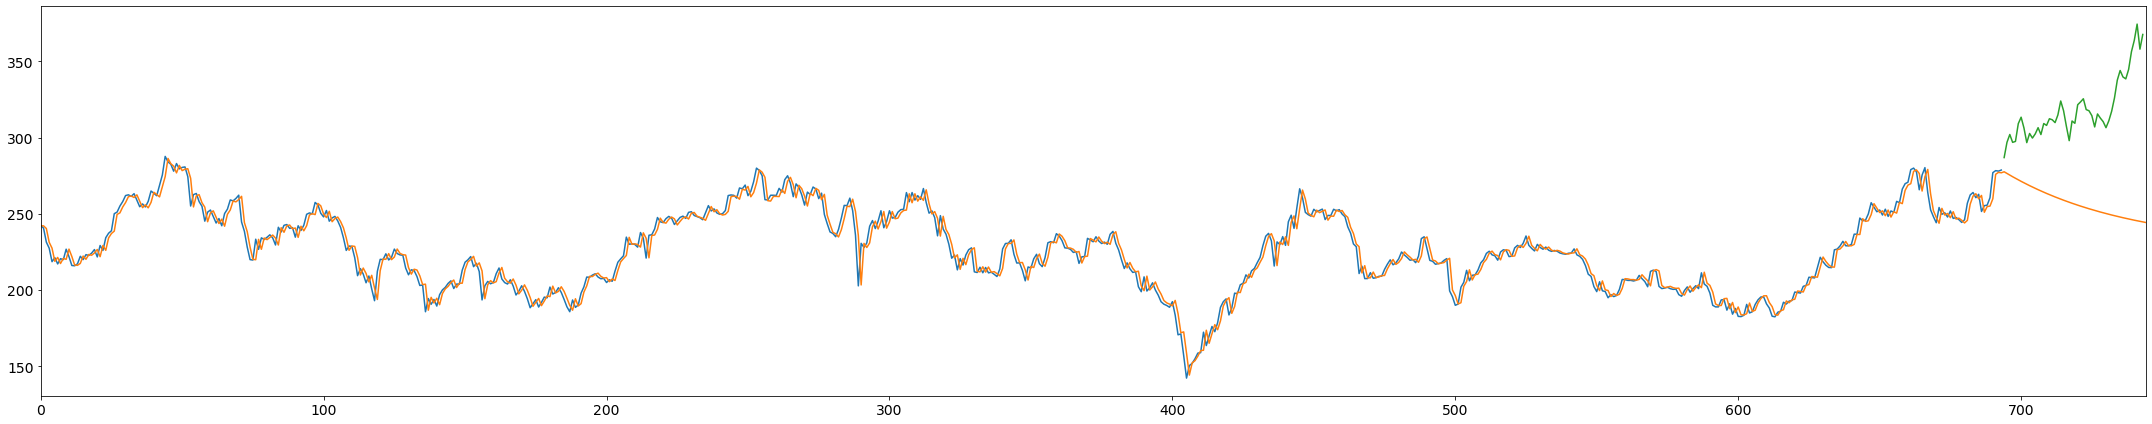

In [36]:
series_tt = pd.Series(data = list(train)+list(test))
series_tp = pd.Series(data = list(train)+list(y_m1))
series_tp2 = pd.Series(data = list(y_m2))

fsize=(30,6)

series_tt[:-50].plot(figsize=fsize, label= 'train', fontsize=14)
# series_tp[-50:].plot(figsize=fsize, label= 'pred', fontsize=14) 
series_tp2.plot(figsize=fsize, label= 'pred', fontsize=14) 
series_tt[-50:].plot(figsize=fsize, label= 'test', fontsize=14) 

plt.tight_layout()
plt.show()

In [56]:
# fsize=(30,15)
# tmp = pd.Series(data=list(model_1.endog[:,0]) + list(y_m1))
# tmp_true = pd.Series(data=list(model_1.endog[:,0]) + list((data['Open']['2017-04-01':].values)[:50]))


# fig, axs = plt.subplots(2,1) 
# tmp[:-50].plot(figsize=fsize, label= 'train', fontsize=14, ax=axs[0]) 
# tmp[-50:].plot(figsize=fsize, label= 'pred', fontsize=14, ax=axs[0]) 
# tmp_true[-50:].plot(figsize=fsize, label= 'pred', fontsize=14, ax=axs[0]) 
# tmp_true.plot(figsize=fsize, label= 'pred', fontsize=14, ax=axs[1]) 
# plt.legend(loc='best') 
# plt.show()

##### 2.5 use AR again (but from `statsmodels.api`)

This library was used [here](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b). It seems that it works without having to be hacked. `NO!` not true!

In [38]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

##### 2.6 use some of the available prediction methods (ARMA)

I had to add a line in the `fit()` method of the `ARMA` class in `ar_model.py`.    
```
self.params = params
```
I do not know if that are the parameters that the predict function wants to have.

In [14]:
from statsmodels.tsa.arima_model import ARMA

In [15]:
train = data['Open']['2014-07-01':'2017-04-01'].values
test = data['Open']['2017-04-01':].values[:50]

In [39]:
model_2 = ARMA(endog=train, exog=None, order=(4,2))
model_2.fit(trend='c', maxiter=500)

In [40]:
model_2.k_ma, model_2.k_lags, model_2.k_constant, model_2.k_trend

(2, 4, 0, 1)

In [41]:
print(len(model_2.params))
model_2.params

7


array([ 2.30186095e+02,  1.09862240e+00, -6.54568220e-01,  5.52992904e-01,
       -3.20502576e-02, -1.53505580e-01,  5.80501594e-01])

In [42]:
y_m2 = model_2.predict(params=model_2.params, start=model_2.endog.shape[0], end=model_2.endog.shape[0]+50)

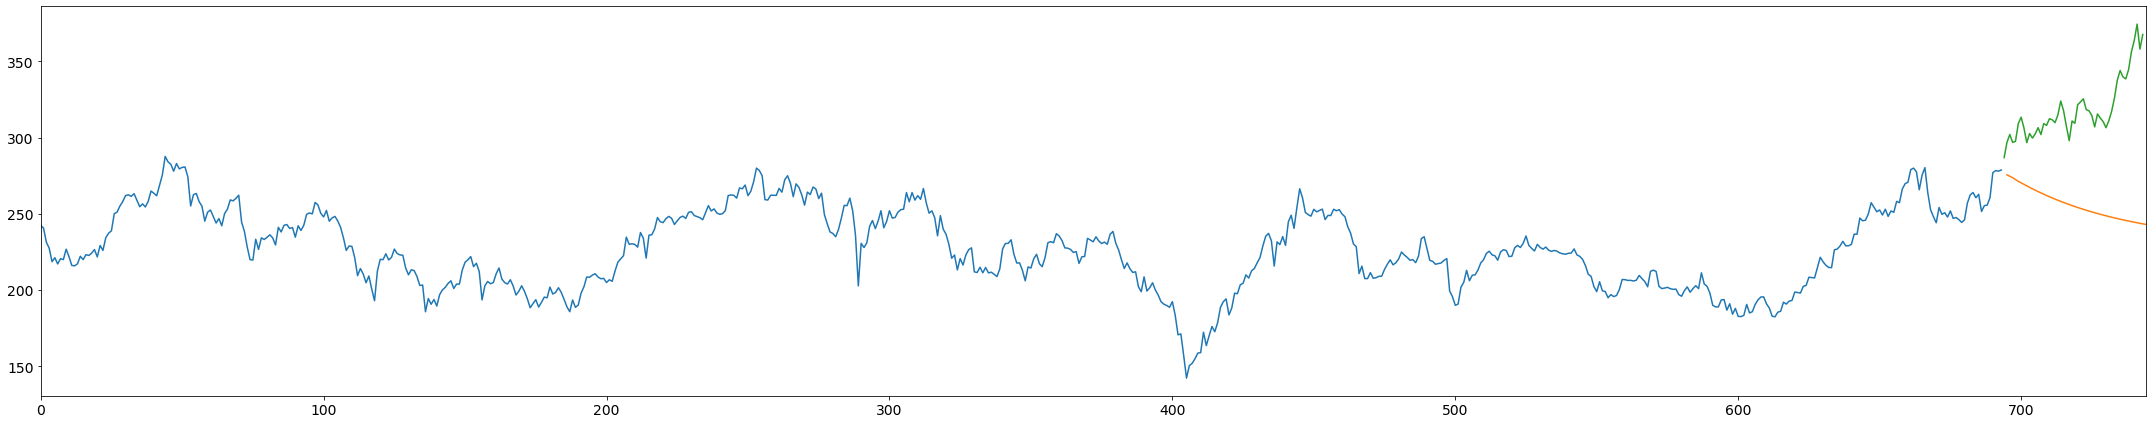

In [43]:
series_tt = pd.Series(data = list(train)+list(test))
series_tp = pd.Series(data = list(train)+list(y_m2))

fsize=(30,6)

series_tt[:-50].plot(figsize=fsize, label= 'train', fontsize=14)
series_tp[-50:].plot(figsize=fsize, label= 'pred', fontsize=14) 
series_tt[-50:].plot(figsize=fsize, label= 'test', fontsize=14) 

plt.tight_layout()
plt.show()

##### 2.7 use some of the available prediction methods (ARIMA) `stable library`?

Have I hacked the corresponding python file?

In [ ]:
train = data['Open']['2014-07-01':'2017-04-01'].values
test = data['Open']['2017-04-01':].values[:50]

In [51]:
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults

In [90]:
model_3 = ARIMA(endog=train, order=(3,1,1))
arima_res = model_3.fit(trend='c', maxiter=500)
# print(model_1.params)
# print(model_1.k_ar)

In [91]:
display(type(model_3))
display(type(arima_res))

statsmodels.tsa.arima_model.ARIMA

statsmodels.tsa.arima_model.ARIMAResultsWrapper

In [74]:
model_3.params # const, p1, p2, p3

array([ 0.01025669, -0.80239536, -0.5182534 , -0.22266286])

In [68]:
model_3.params # const, p1, p2, p3, q1

array([ 8.55310523e-04, -4.24746903e-02,  2.39674471e-02,  3.70437245e-02,
       -9.99958380e-01])

In [66]:
model_3.params # const, p1, p2, q1

array([ 8.47339948e-04, -4.18099588e-02,  2.22860068e-02, -9.99941117e-01])

In [92]:
arima_res.params

array([ 0.05135472, -0.15919726,  0.01831594,  0.03965275,  0.11615954])

In [93]:
y_m1 = model_3.predict(params=arima_res.params, start=model_3.endog.shape[0], end=model_3.endog.shape[0]+49, typ='levels') # contains 51 el instead of 50!
y_m2 = model_3.predict(params=arima_res.params, start=2, end=model_3.endog.shape[0]+49, typ='levels')

y_m2 = np.array([y_m2[0],y_m2[0]] + list(y_m2))

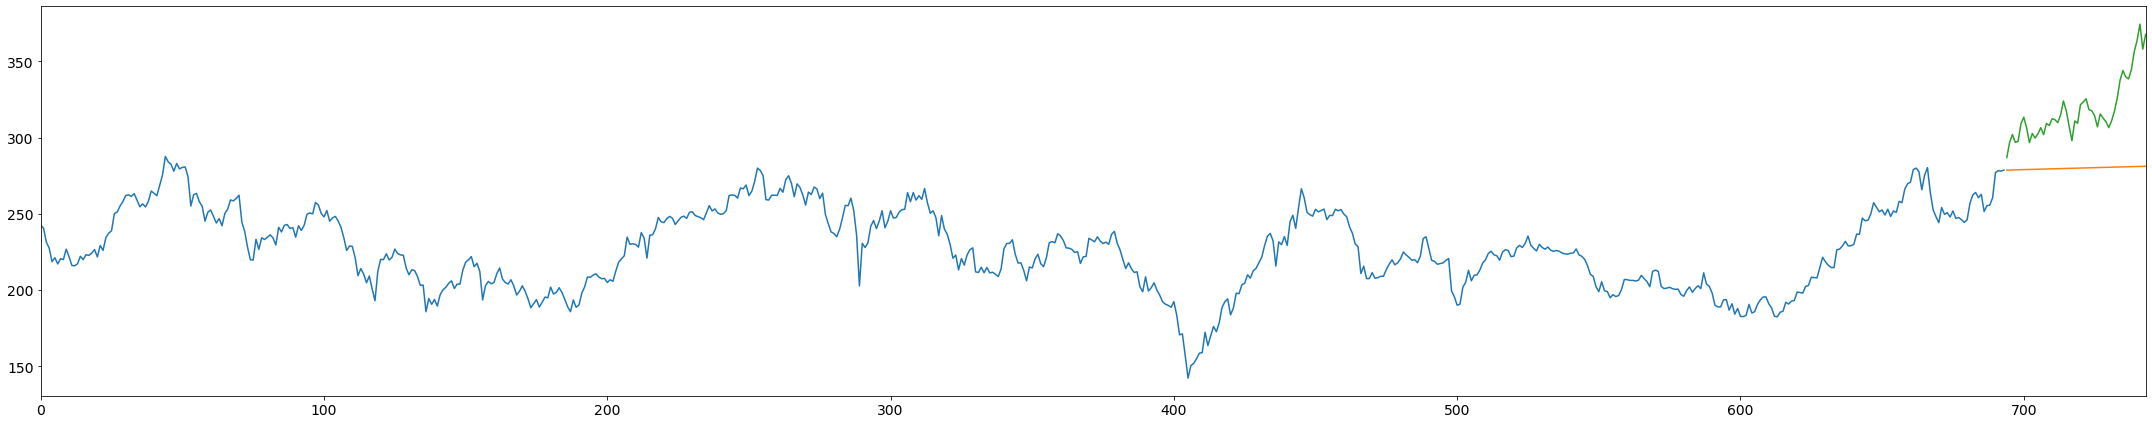

In [94]:
series_tt = pd.Series(data = list(train)+list(test))
series_tp = pd.Series(data = list(train)+list(y_m1))
series_tp2 = pd.Series(data = list(y_m2))

fsize=(30,6)

series_tt[:-50].plot(figsize=fsize, label= 'train', fontsize=14)
series_tp[-50:].plot(figsize=fsize, label= 'pred', fontsize=14) 
# series_tp2.plot(figsize=fsize, label= 'pred', fontsize=14) 
series_tt[-50:].plot(figsize=fsize, label= 'test', fontsize=14) 

plt.tight_layout()
plt.show()

In [95]:
arima_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  693
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -2202.260
Method:                       css-mle   S.D. of innovations              5.806
Date:                Mon, 24 Jun 2019   AIC                           4416.520
Time:                        00:37:28   BIC                           4443.766
Sample:                             1   HQIC                          4427.057
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0514      0.224      0.230      0.818      -0.387       0.489
ar.L1.D.y     -0.1592      0.447     -0.356      0.722      -1.036       0.718
ar.L2.D.y      0.0183      0.043      0.427      0.670      -0.066       0.102
ar.L3.D.y      0.0397      0.039      1.024      0.306      -0.036       0.116
ma.L1.D.y      0.1162      0.446      0.260      0.795      -0.759       0.991
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.8405           -2.1088j            2.7990           -0.3642
AR.2           -1.8405           +2.1088j            2.7990            0.3642
AR.3            3.2190           -0.0000j            3.2190           -0.0000
MA.1           -8.6088           +0.0000j            8.6088            0.5000
-----------------------------------------------------------------------------
"""

In [96]:
arima_res.pvalues

array([0.81834957, 0.72204985, 0.66966927, 0.30616374, 0.79477085])

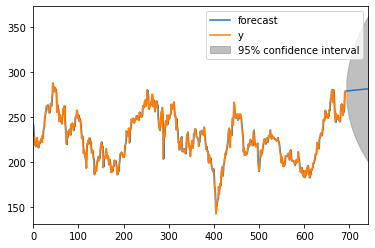

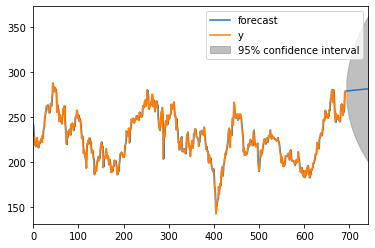

In [100]:
arima_res.plot_predict(start=1, end=model_3.endog.shape[0]+49, plot_insample=False)

In [ ]:
arima_res.

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

TODO later.

### 3 Vector based approaches

##### 3.1 Example from documentation VAR

In [10]:
# some example data
import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.base.datetools import dates_from_str

mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]


quarterly = dates_from_str(quarterly)
mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

model = VAR(data)

/anaconda3/envs/ts/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
/anaconda3/envs/ts/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [13]:
print(data.shape)
data.head(2)

(202, 3)


,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131


In [14]:
# To actually do the estimation, call the fit method with the desired lag order. Or you can have the model select a lag order based on a standard information criterion (see below):
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Jun, 2019
Time:                     09:36:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

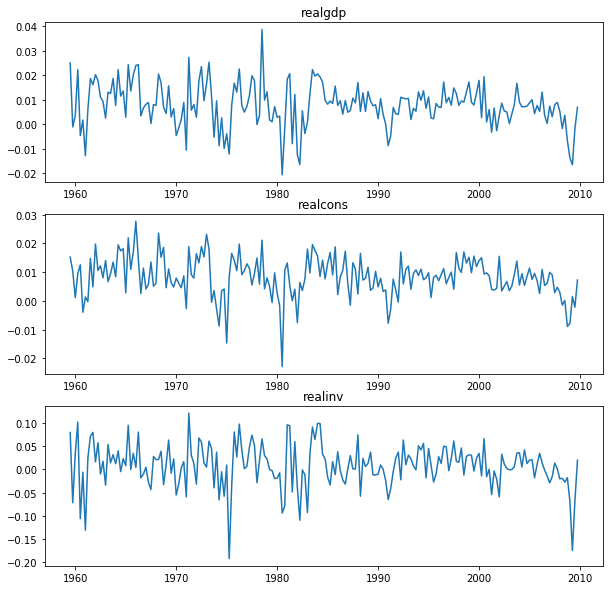

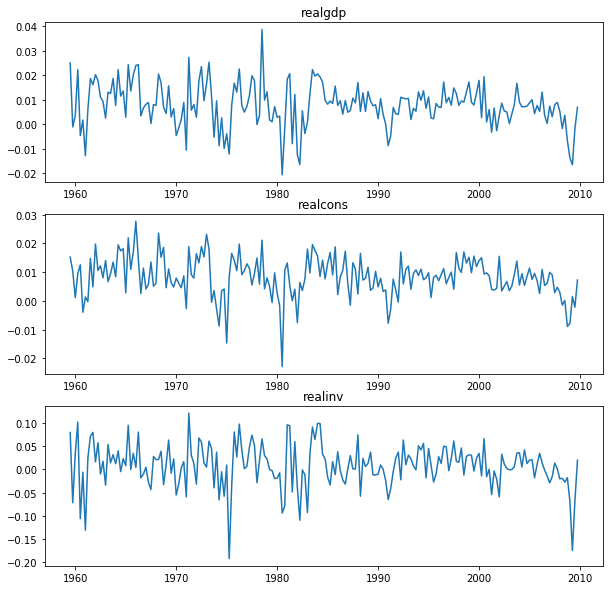

In [16]:
results.plot()

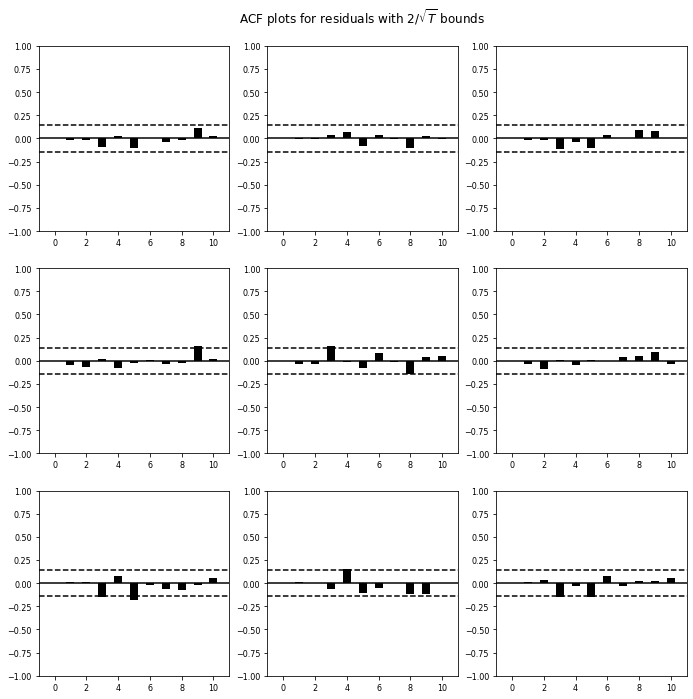

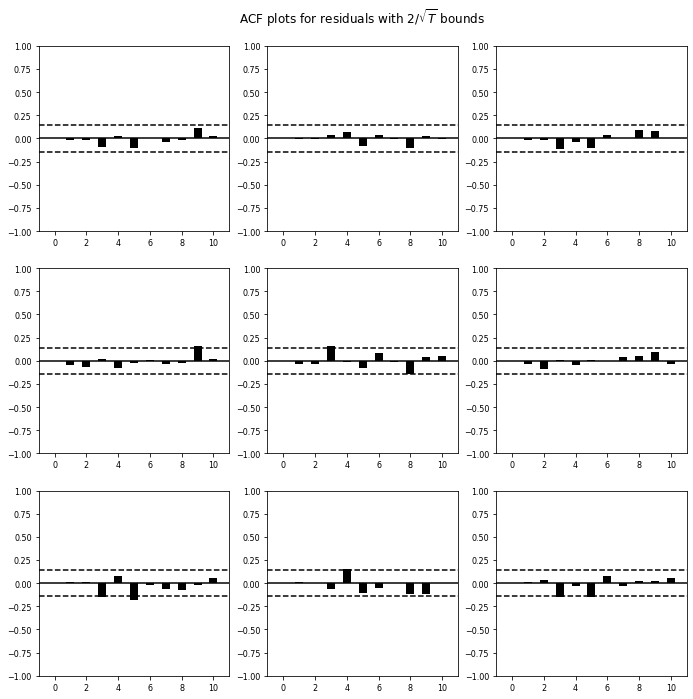

In [17]:
results.plot_acorr()

In [18]:
# Lag order selection
model.select_order(15)

In [19]:
results = model.fit(maxlags=15, ic='aic')

In [20]:
results.k_ar

3

In [23]:
results.forecast(data.values[-results.k_ar:], 5)

array([[ 0.00616044,  0.00500006,  0.00916198],
       [ 0.00427559,  0.00344836, -0.00238478],
       [ 0.00416634,  0.0070728 , -0.01193629],
       [ 0.00557873,  0.00642784,  0.00147152],
       [ 0.00626431,  0.00666715,  0.00379567]])

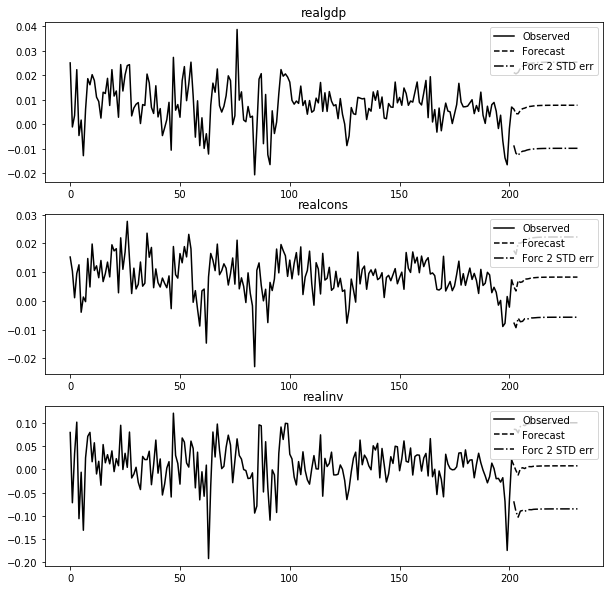

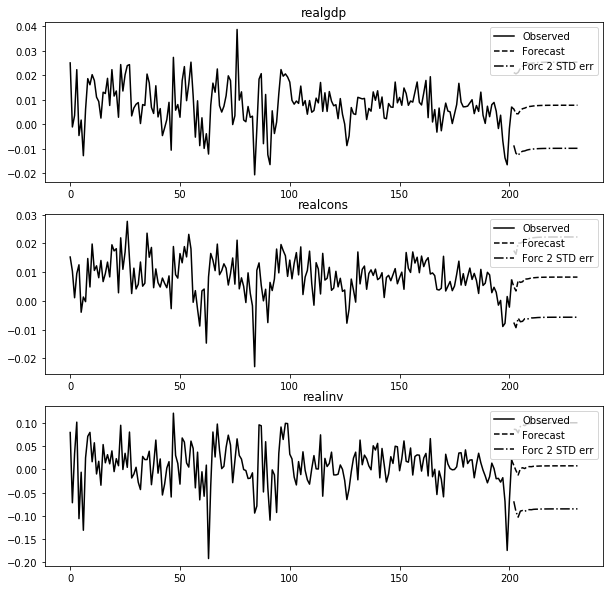

In [25]:
results.plot_forecast(30)

##### 3.2 Dynamic VAR

In [33]:
np.random.seed(1)
import datetime as dt
import pandas.util.testing as ptest

ptest.N = 500

data = ptest.makeTimeDataFrame().cumsum(0)
data

,A,B,C,D
2000-01-03,1.624345,-1.719394,-0.153236,1.301225
2000-01-04,1.012589,-1.662273,-2.585745,0.988833
2000-01-05,0.484417,-2.461821,-2.077760,0.717604
2000-01-06,-0.588551,-2.753416,-2.401793,2.580517
2000-01-07,0.276856,-3.012398,-3.912869,1.937644
2000-01-10,-2.024682,-2.823105,-4.784291,2.772702
2000-01-11,-0.279871,-3.386894,-5.649121,2.409648
2000-01-12,-1.041078,-3.297208,-5.040372,0.977581
2000-01-13,-0.722039,-3.898364,-4.478734,0.811562
2000-01-14,-0.971409,-3.342291,-2.963984,1.980488


In [36]:
var = DynamicVAR(data, lag_order=6, window_type='expanding')

In [37]:
var.coefs

<class 'pandas.core.panel.Panel'>
Dimensions: 25 (items) x 469 (major_axis) x 4 (minor_axis)
Items axis: L1.A to intercept
Major_axis axis: 2000-02-15 00:00:00 to 2001-11-30 00:00:00
Minor_axis axis: A to D

In [38]:
var.coefs.minor_xs('A').info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 469 entries, 2000-02-15 to 2001-11-30
Freq: B
Data columns (total 25 columns):
L1.A         469 non-null float64
L1.B         469 non-null float64
L1.C         469 non-null float64
L1.D         469 non-null float64
L2.A         469 non-null float64
L2.B         469 non-null float64
L2.C         469 non-null float64
L2.D         469 non-null float64
L3.A         469 non-null float64
L3.B         469 non-null float64
L3.C         469 non-null float64
L3.D         469 non-null float64
L4.A         469 non-null float64
L4.B         469 non-null float64
L4.C         469 non-null float64
L4.D         469 non-null float64
L5.A         469 non-null float64
L5.B         469 non-null float64
L5.C         469 non-null float64
L5.D         469 non-null float64
L6.A         469 non-null float64
L6.B         469 non-null float64
L6.C         469 non-null float64
L6.D         469 non-null float64
intercept    469 non-null float64
dtypes: float64(25

In [39]:
# coefficients on 11/30/2001
var.coefs.major_xs(dt.datetime(2001, 11, 30)).T

,A,B,C,D
L1.A,0.976360,0.051322,-0.002439,-0.000814
L1.B,0.053469,0.937402,0.011645,0.023373
L1.C,0.027809,0.017013,0.976911,0.136096
L1.D,0.028732,0.048869,0.058116,1.021539
L2.A,0.018948,-0.080841,-0.100028,-0.028807
L2.B,-0.022681,0.073614,0.044464,0.026627
L2.C,-0.028369,0.009803,-0.006339,-0.234848
L2.D,-0.111332,-0.126706,-0.082025,-0.086060
L3.A,-0.056361,-0.025246,0.105912,0.011275
L3.B,-0.035730,-0.073419,-0.071116,-0.063589


In [42]:
var.forecast(1).head(2)

,A,B,C,D
2000-02-16,8.193764,23.757890,18.290830,0.835123
2000-02-17,0.273586,-0.458176,-5.907072,-18.693782


In [43]:
var.forecast(2).head(2)

,A,B,C,D
2000-02-17,133.322372,-49.198742,22.296081,6.355368
2000-02-18,-8.960677,-5.618925,-14.737234,-16.526681


In [44]:
var.forecast(10).head(2)

,A,B,C,D
2000-02-29,845.514290,-1341.702989,808.567720,346.610072
2000-03-01,-250.500909,-41.932174,137.484301,182.124352


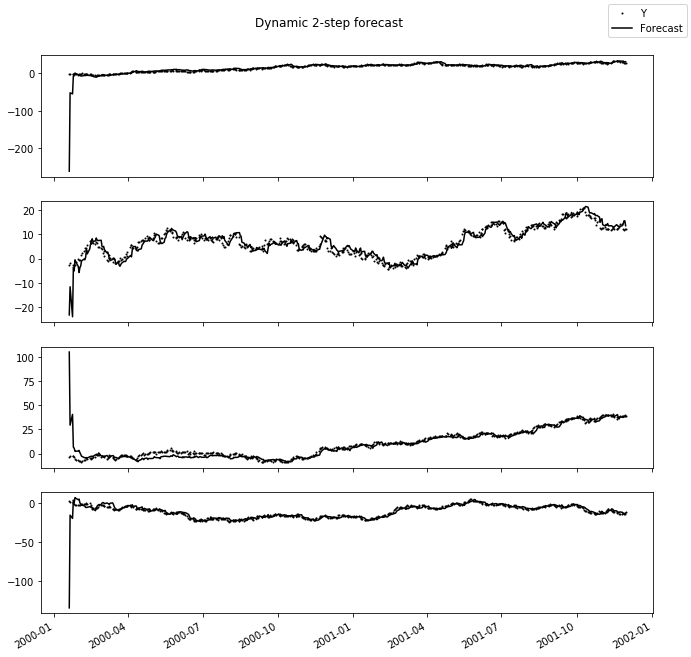

In [31]:
var.plot_forecast(2)

##### 3.3 rest

### 4 SARIMAX

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO

In [2]:
# Dataset
friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content

In [3]:
# Dataset
raw = pd.read_stata(BytesIO(friedman2))
raw.index = raw.time
data = raw.loc[:'1981']

# Variables
endog = data.loc['1959':, 'consump']
exog = sm.add_constant(data.loc['1959':, 'm2'])
nobs = endog.shape[0]

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog.loc[:'1978-01-01'], exog=exog.loc[:'1978-01-01'], order=(1,0,1))
fit_res = mod.fit(disp=False)
print(fit_res.summary())

                           Statespace Model Results                           
Dep. Variable:                consump   No. Observations:                   77
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -243.316
Date:                Mon, 11 Nov 2019   AIC                            496.633
Time:                        17:10:16   BIC                            508.352
Sample:                    01-01-1959   HQIC                           501.320
                         - 01-01-1978                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6777     18.491      0.037      0.971     -35.565      36.920
m2             1.0379      0.021     50.330      0.000       0.997       1.078
ar.L1          0.8775      0.059     14.859      0.0

/Users/A.IVA/opt/anaconda3/envs/stargazers/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/A.IVA/opt/anaconda3/envs/stargazers/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [5]:
# display(data.head(3))
display(endog.head(3))
display(exog.head(3))

time
1959-01-01    310.399994
1959-04-01    316.399994
1959-07-01    321.700012
Name: consump, dtype: float32

,const,m2
time,,
1959-01-01,1.0,289.149994
1959-04-01,1.0,294.049988
1959-07-01,1.0,296.730011


In [6]:
fit_res.params

const      0.677727
m2         1.037879
ar.L1      0.877544
ma.L1      0.277096
sigma2    31.697739
dtype: float64

In [7]:
mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,0,1))
res = mod.filter(fit_res.params)

/Users/A.IVA/opt/anaconda3/envs/stargazers/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [8]:
res.params

const      0.677727
m2         1.037879
ar.L1      0.877544
ma.L1      0.277096
sigma2    31.697739
dtype: float64

In [17]:
res.get_prediction()

In [ ]:
res.get_forecast()

In [ ]:
mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,0,1))
mod.update(params=fit_res.params)

In [13]:
type(res)

statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper

In [14]:
res.params

const      0.677727
m2         1.037879
ar.L1      0.877544
ma.L1      0.277096
sigma2    31.697739
dtype: float64

In [9]:
predict = res.get_prediction()
predict_ci = predict.conf_int()
predict_mean = predict.predicted_mean

In [10]:
display(predict_mean.head(3))
display(predict_ci.head(3))

1959-01-01    300.780410
1959-04-01    314.699690
1959-07-01    318.333771
Freq: QS-OCT, dtype: float64

,lower consump,upper consump
1959-01-01,272.008310,329.552510
1959-04-01,303.309354,326.090027
1959-07-01,307.273021,329.394522


In [11]:
# Dynamic predictions
predict_dy = res.get_prediction(dynamic='1978-01-01')
predict_dy_ci = predict_dy.conf_int()
predict_dy_mean = predict_dy.predicted_mean

In [22]:
(predict_mean - predict_dy_mean).head(80)

1959-01-01     0.000000
1959-04-01     0.000000
1959-07-01     0.000000
1959-10-01     0.000000
1960-01-01     0.000000
                ...    
1977-10-01     0.000000
1978-01-01     0.000000
1978-04-01     6.635215
1978-07-01    44.219420
1978-10-01    38.978404
Freq: QS-OCT, Length: 80, dtype: float64

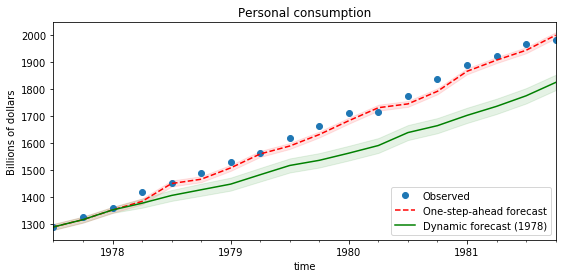

In [23]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

# Plot data points
data.loc['1977-07-01':, 'consump'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='g', label='Dynamic forecast (1978)')
ci = predict_dy_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

### -99 Rest

In [84]:
model_2._transparams

<bound method ARMA._transparams of <statsmodels.tsa.arima_model.ARMA object at 0x125e8a240>>

In [ ]:
daily_train_.Count.plot(figsize=(20,8), title= 'Daily Ridership', fontsize=14, label='train') 
daily_valid_.Count.plot(figsize=(20,8), title= 'Daily Ridership', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

array([ 17.  ,  19.  ,  25.79, ..., 305.5 , 302.5 , 302.5 ])

In [ ]:
from sklearn import metrics
metrics.mean_squared_error(time_log,time_log_ewma_diff)

In [ ]:
from statsmodels.tsa.tsatools import ExponentialSmoothing, SimpleExpSmoothing, Holt